In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [147]:
import pandas as pd
import numpy as np

import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords')
nltk.download('punkt')

from nltk.stem import WordNetLemmatizer #this is used in lemmatization
nltk.download('wordnet') # this is required for lemmatization

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import  recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import  auc
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [148]:

#reading the data
df_data = pd.read_csv('/content/drive/My Drive/NLP_PRACTICE/sentiment_stock/Data.csv',encoding='ISO-8859-1')

In [149]:
df_data.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2000-01-03,0,A 'hindrance to operations': extracts from the...,Scorecard,Hughes' instant hit buoys Blues,Jack gets his skates on at ice-cold Alex,Chaos as Maracana builds up for United,Depleted Leicester prevail as Elliott spoils E...,Hungry Spurs sense rich pickings,Gunners so wide of an easy target,Derby raise a glass to Strupar's debut double,"Southgate strikes, Leeds pay the penalty",Hammers hand Robson a youthful lesson,Saints party like it's 1999,Wear wolves have turned into lambs,Stump mike catches testy Gough's taunt,Langer escapes to hit 167,Flintoff injury piles on woe for England,Hunters threaten Jospin with new battle of the...,Kohl's successor drawn into scandal,The difference between men and women,"Sara Denver, nurse turned solicitor",Diana's landmine crusade put Tories in a panic,Yeltsin's resignation caught opposition flat-f...,Russian roulette,Sold out,Recovering a title
1,2000-01-04,0,Scorecard,The best lake scene,Leader: German sleaze inquiry,"Cheerio, boyo",The main recommendations,Has Cubie killed fees?,Has Cubie killed fees?,Has Cubie killed fees?,Hopkins 'furious' at Foster's lack of Hannibal...,Has Cubie killed fees?,A tale of two tails,I say what I like and I like what I say,"Elbows, Eyes and Nipples",Task force to assess risk of asteroid collision,How I found myself at last,On the critical list,The timing of their lives,Dear doctor,Irish court halts IRA man's extradition to Nor...,Burundi peace initiative fades after rebels re...,PE points the way forward to the ECB,Campaigners keep up pressure on Nazi war crime...,Jane Ratcliffe,Yet more things you wouldn't know without the ...,Millennium bug fails to bite
2,2000-01-05,0,Coventry caught on counter by Flo,United's rivals on the road to Rio,Thatcher issues defence before trial by video,Police help Smith lay down the law at Everton,Tale of Trautmann bears two more retellings,England on the rack,Pakistan retaliate with call for video of Walsh,Cullinan continues his Cape monopoly,McGrath puts India out of their misery,Blair Witch bandwagon rolls on,Pele turns up heat on Ferguson,Party divided over Kohl slush fund scandal,Manchester United (England),Women in record South Pole walk,Vasco da Gama (Brazil),South Melbourne (Australia),Necaxa (Mexico),Real Madrid (Spain),Raja Casablanca (Morocco),Corinthians (Brazil),Tony's pet project,Al Nassr (Saudi Arabia),Ideal Holmes show,Pinochet leaves hospital after tests,Useful links
3,2000-01-06,1,Pilgrim knows how to progress,Thatcher facing ban,McIlroy calls for Irish fighting spirit,Leicester bin stadium blueprint,United braced for Mexican wave,"Auntie back in fashion, even if the dress look...",Shoaib appeal goes to the top,Hussain hurt by 'shambles' but lays blame on e...,England's decade of disasters,Revenge is sweet for jubilant Cronje,"Our choice, not theirs",Profile of former US Nazi Party officer Willia...,New evidence shows record of war crimes suspec...,The rise of the supernerds,Written on the body,Putin admits Yeltsin quit to give him a head s...,BBC worst hit as digital TV begins to bite,How much can you pay for...,Christmas glitches,"Upending a table, Chopping a line and Scoring ...","Scientific evidence 'unreliable', defence claims",Fusco wins judicial review in extradition case,Rebels thwart Russian advance,Blair orders shake-up of failing NHS,Lessons of law's hard heart
4,2000-01-07,1,Hitches and Horlocks,Beckham off but United survive,Breast cancer screening,Alan Parker,Guardian readers: are you all whingers?,Hollywood Beyond,Ashes and diamonds,Whingers - a formidable minority,Alan Parker - part two,"Thuggery, Toxins and Ties",Met faces fresh attack on race crime,Everton fans top racist 'league of shame',"Our breasts, ourselves",Russia's new boss has an extremely strange his...,Always and forever,Most everywhere: UDIs,Most wanted: Chloe lunettes,

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


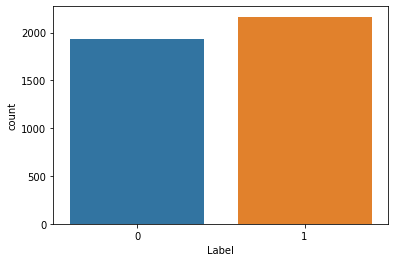

In [150]:
#checkig the distribution of class
sns.countplot(df_data['Label'])

In [102]:
#dropping the date columns as it is of no use to us

#df_data.drop(columns=['Date'],axis=1,inplace=True)

In [103]:
train = df_data[df_data['Date'] < '20150101']
test = df_data[df_data['Date'] > '20141231']

In [107]:
df_data=train.iloc[:,2:27]
df_data.replace("[^a-zA-Z]"," ",regex=True, inplace=True)

In [108]:
df_data.head(2)

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,A hindrance to operations extracts from the...,Scorecard,Hughes instant hit buoys Blues,Jack gets his skates on at ice cold Alex,Chaos as Maracana builds up for United,Depleted Leicester prevail as Elliott spoils E...,Hungry Spurs sense rich pickings,Gunners so wide of an easy target,Derby raise a glass to Strupar s debut double,Southgate strikes Leeds pay the penalty,Hammers hand Robson a youthful lesson,Saints party like it s,Wear wolves have turned into lambs,Stump mike catches testy Gough s taunt,Langer escapes to hit,Flintoff injury piles on woe for England,Hunters threaten Jospin with new battle of the...,Kohl s successor drawn into scandal,The difference between men and women,Sara Denver nurse turned solicitor,Diana s landmine crusade put Tories in a panic,Yeltsin s resignation caught opposition flat f...,Russian roulette,Sold out,Recovering a title
1,Scorecard,The best lake scene,Leader German sleaze inquiry,Cheerio boyo,The main recommendations,Has Cubie killed fees,Has Cubie killed fees,Has Cubie killed fees,Hopkins furious at Foster s lack of Hannibal...,Has Cubie killed fees,A tale of two tails,I say what I like and I like what I say,Elbows Eyes and Nipples,Task force to assess risk of asteroid collision,How I found myself at last,On the critical list,The timing of their lives,Dear doctor,Irish court halts IRA man s extradition to Nor...,Burundi peace initiative fades after rebels re...,PE points the way forward to the ECB,Campaigners keep up pressure on Nazi war crime...,Jane Ratcliffe,Yet more things you wouldn t know without the ...,Millennium bug fails to bite


In [109]:
# combing all the different columns of text on one single column

news = []
news = df_data[df_data.columns[0:]].apply(lambda x: ' '.join(x.dropna().astype(str)),axis=1)

In [119]:
#converting into lower case
news_lower = [news[i].lower() for i in range(0,len(news))]

In [121]:
news_lower[0]

'a  hindrance to operations   extracts from the leaked reports scorecard hughes  instant hit buoys blues jack gets his skates on at ice cold alex chaos as maracana builds up for united depleted leicester prevail as elliott spoils everton s party hungry spurs sense rich pickings gunners so wide of an easy target derby raise a glass to strupar s debut double southgate strikes  leeds pay the penalty hammers hand robson a youthful lesson saints party like it s      wear wolves have turned into lambs stump mike catches testy gough s taunt langer escapes to hit     flintoff injury piles on woe for england hunters threaten jospin with new battle of the somme kohl s successor drawn into scandal the difference between men and women sara denver  nurse turned solicitor diana s landmine crusade put tories in a panic yeltsin s resignation caught opposition flat footed russian roulette sold out recovering a title'

In [122]:
# def text_process(df,columns):

#   lamm = WordNetLemmatizer()
#   tokenizer = RegexpTokenizer(r'\w+')
#   corpus = []
#   cleaned_corpus = []

#   for i in df[columns]:
    
#     #remove url's
#     sentence = re.sub(r"http\S+", " ", i).lower()

#     # #removing characters other than alphabets
#     sentence = re.sub('[^a-zA-Z]',' ',sentence)

#     # #removing spaces
#     cleaned_sentence = re.sub(r'\s+',' ',sentence)

#     #tokenize
#     cleaned_sentence = tokenizer.tokenize(cleaned_sentence)

#     # # remove any stopwords 
#     cleaned_sentence = [lamm.lemmatize(word) for word in cleaned_sentence if word.lower() not in stopwords.words('english')]

#      # # Join the characters again to form the string.
#     cleaned_sentence = ' '.join(cleaned_sentence)

#     corpus.append(cleaned_sentence)
#     cleaned_corpus.append(cleaned_sentence)


#   return corpus, cleaned_corpus

In [51]:
# #applying the text_process function on caption column of dev set 
# df_data['Cleaned Text'], cleaned_corpus = text_process(df_data,columns='Text')

## **Using Bags of word Model**

In [123]:
## implement BAG OF WORDS
countvector=CountVectorizer(ngram_range=(2,2))
x=countvector.fit_transform(news_lower)

In [124]:
def evaluate_model(y_test, predicted, predicted_prob, show_thresholds=True, figsize=(25,5)):
    classes = np.unique(y_test)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    ## Accuray e AUC
    accuracy = metrics.accuracy_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted_prob)
    print("Accuracy (overall correct predictions):",  round(accuracy,2))
    print("Auc:", round(auc,2))
    
    ## Precision e Recall
    recall = metrics.recall_score(y_test, predicted)  #= true 1s / all 1s in test (got and missed)
    precision = metrics.precision_score(y_test, predicted)  #= true 1s / all 1s predicted (true 1s + false 1s)
    f1 = metrics.f1_score(y_test, predicted)  #=2 * (precision * recall) / (precision + recall)
    print("Recall (all 1s predicted right):", round(recall,2))  #true positive rate, how many 1s I got
    print("Precision (confidence when predicting a 1):", round(precision,2))  #how many 1s were really 1s
    print("F1 score:", round(f1,2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in classes]))
       
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
    sns.heatmap(cm, annot=True, annot_kws={"size":15}, fmt='d', ax=ax[0], cmap=plt.cm.Blues, cbar=False)
    ax[0].set(xlabel="Pred", ylabel="True", title="Confusion matrix")
    ax[0].set_yticklabels(labels=classes, rotation=0)
 
    ## Plot roc
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_prob)    
    ax[1].plot(fpr, tpr, color='darkorange', lw=3, label='area = %0.2f' % metrics.auc(fpr, tpr))
    ax[1].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[1].hlines(y=recall, xmin=-0.05, xmax=1-cm[0,0]/(cm[0,0]+cm[0,1]), color='red', linestyle='--', alpha=0.7, label="chosen threshold")
    ax[1].vlines(x=1-cm[0,0]/(cm[0,0]+cm[0,1]), ymin=0, ymax=recall, color='red', linestyle='--', alpha=0.7)
    ax[1].set(xlim=[-0.05,1], ylim=[0.0,1.05], xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="ROC Curve")     
    ax[1].legend(loc="lower right")
    ax[1].grid(True)
    if show_thresholds is True:
        thres_in_plot = []
        for i,t in enumerate(thresholds):
            t = np.round(t,1)
            if t not in thres_in_plot:
                ax[1].annotate(t, xy=(fpr[i],tpr[i]), xytext=(fpr[i],tpr[i]), textcoords='offset points', ha='left', va='bottom')
                thres_in_plot.append(t)
            else:
                next
    
    ## Plot precision-recall curve
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, predicted_prob)
    ax[2].plot(recalls, precisions, color='darkorange', lw=3, label='area = %0.2f' % metrics.auc(recalls, precisions))
    ax[2].plot([0,1], [(cm[1,0]+cm[1,0])/len(y_test), (cm[1,0]+cm[1,0])/len(y_test)], linestyle='--', color='navy', lw=3)
    ax[2].hlines(y=precision, xmin=0, xmax=recall, color='red', linestyle='--', alpha=0.7, label="chosen threshold")
    ax[2].vlines(x=recall, ymin=0, ymax=precision, color='red', linestyle='--', alpha=0.7)
    ax[2].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
    ax[2].legend(loc="lower left")
    ax[2].grid(True)
    if show_thresholds is True:
        thres_in_plot = []
        for i,t in enumerate(thresholds):
            t = np.round(t,1)
            if t not in thres_in_plot:
                ax[2].annotate(np.round(t,1), xy=(recalls[i],precisions[i]), xytext=(recalls[i],precisions[i]), textcoords='offset points', ha='right', va='bottom')
                thres_in_plot.append(t)
            else:
                next
    plt.show()

**Using Random Forest**

In [129]:
# implement RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
randomclassifier=RandomForestClassifier(n_estimators=200,criterion='entropy')
randomclassifier.fit(x,train['Label'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [130]:
## Predict for the Test Dataset
test_transform= []
for row in range(0,len(test.index)):
    test_transform.append(' '.join(str(x) for x in test.iloc[row,2:27]))
test_dataset = countvector.transform(test_transform)
predictions = randomclassifier.predict(test_dataset)

In [134]:
predicted_prob = randomclassifier.predict_proba(test_dataset)[:,1]

Accuracy (overall correct predictions): 0.86
Auc: 0.95
Recall (all 1s predicted right): 0.95
Precision (confidence when predicting a 1): 0.81
F1 score: 0.87
Detail:
              precision    recall  f1-score   support

           0       0.93      0.76      0.84       186
           1       0.81      0.95      0.87       192

    accuracy                           0.86       378
   macro avg       0.87      0.86      0.86       378
weighted avg       0.87      0.86      0.86       378



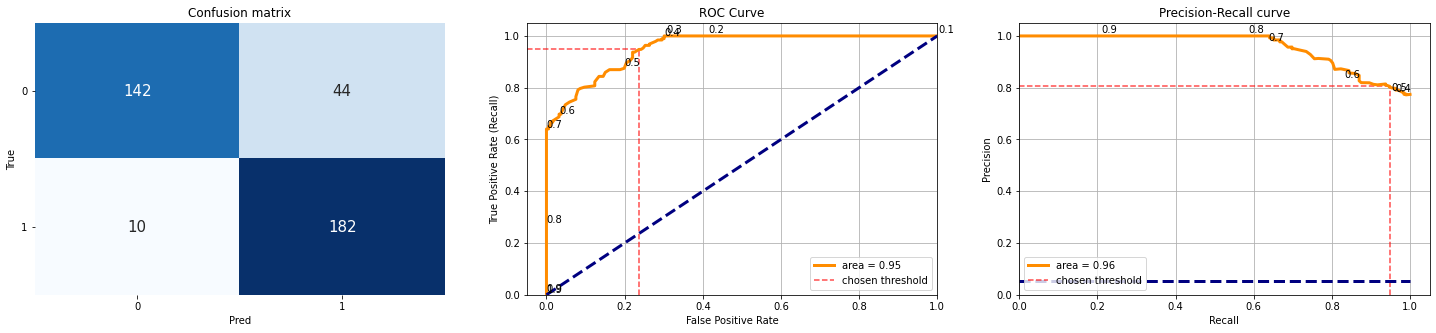

In [135]:
evaluate_model(test['Label'],predictions, predicted_prob, figsize=(25,5))

**Using MultinomialNB**

Accuracy (overall correct predictions): 0.85
Auc: 0.94
Recall (all 1s predicted right): 0.95
Precision (confidence when predicting a 1): 0.79
F1 score: 0.86
Detail:
              precision    recall  f1-score   support

           0       0.93      0.74      0.83       186
           1       0.79      0.95      0.86       192

    accuracy                           0.85       378
   macro avg       0.86      0.84      0.84       378
weighted avg       0.86      0.85      0.84       378



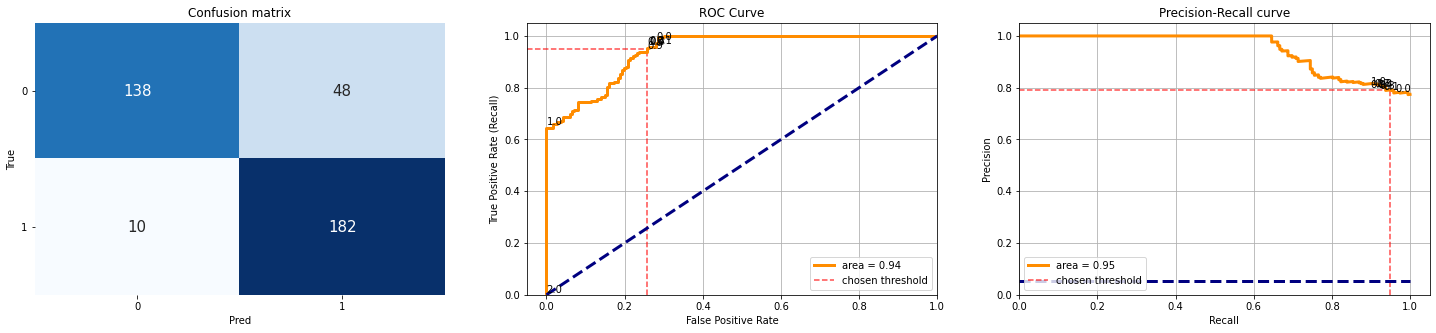

In [137]:
from sklearn.naive_bayes import MultinomialNB
nb=MultinomialNB()
nb.fit(x,train['Label'])
predict_MNB = nb.predict(test_dataset)
predicted_prob = nb.predict_proba(test_dataset)[:,1]
evaluate_model(test['Label'],predict_MNB, predicted_prob, figsize=(25,5))